## Stage 1: Scope

### Agent Scope: User Clarification + Brief Generation

- Challenges:
    - Users generally do not provide sufficient context in their intial request.
    - It often lacks context in various avenues such as:
        - 1. Scope and Boundaries: What should be included/excluded
        - 2. Audience and Purpose: Who is the research for and why
        - 3. Specific Requirements: Sources, contraints and timeframes if necessary
        - 4. Term Clarifications: Domain specific terms and acronyms and what they mean

- In this case, it is better to clarify the user response rather than making assumptions and providing the wrong output

  

### Importing Python scripts

- research_utils: This python file is created to retrieve messages and prompt formats
- deep_research_prompts.prompts: This python file is created to define the prompt template for user clarification

In [1]:
## clarify_with_user_instructions: Gathering necessary context from the user for research purposes

from deep_research_prompts.prompts import clarify_with_user_instructions
from research_utils import show_prompt
show_prompt(clarify_with_user_instructions, "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  RULE: Before answering, you MUST ask at least one clarifying question unless the user has already provided     │
│  enough information for you to start research.                                                                  │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

- %%writefile <file_pathway>: This method is used to write a file in the desired file location for effective tracking

In [ ]:
%%writefile state_scope.py
## Define State Scope
## This is used to define the different agent states right from user clarification to brief generation

"""State Definitions and Pydantic Schemas for Research Scoping.

This defines the state objects and structured schemas used for
the research agent scoping workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

## STATE DEFINITIONS

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """

    ## Research brief generated from user conversation history
    research_brief: Optional[str]
    ## Messages exchanged with the supervisor agent for coordination
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    ## Raw unprocessed research notes collected during the research phase
    raw_notes: Annotated[list[str], operator.add] = []
    ## Processed and structured notes ready for report generation
    notes: Annotated[list[str], operator.add] = []
    ## Final formatted research report
    final_report: str

## STRUCTURED OUTPUT SCHEMAS

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

In [ ]:
%%writefile research_agent_scope.py

## Agent Scope Definition
## All the required functions and agent scope is defined for easy retrieval

"""User Clarification and Research Brief Generation.

This module implements the scoping phase of the research workflow, where we:
1. Assess if the user's request needs clarification
2. Generate a detailed research brief from the conversation

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with research.
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_prompts.prompts import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
from state_scope import AgentState, ClarifyWithUser, ResearchQuestion, AgentInputState

## UTILITY FUNCTIONS

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    ## Windows Date Format: "%a %b %#d, %Y"
    ## Linux Date Format: "%a %b %-d, %Y"
    dt = datetime.now()
    return dt.strftime("%a %b %#d, %Y")
    # try:
    #     return dt.strftime("%a %b %#d, %Y")
    # except ValueError:
    #     return dt.strftime("%a %b %-d, %Y")

## CONFIGURATION

## Initialize model
model = init_chat_model(model="ollama:llama3.1:8b", temperature=0.4)

## WORKFLOW NODES

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Determine if the user's request contains sufficient information to proceed with research.

    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    ## Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    ## Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])

    ## Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive research brief.

    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    ## Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)

    ## Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])

    ## Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

## GRAPH CONSTRUCTION

## Build the scoping workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

## Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

## Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

## Compile the workflow
scope_research = deep_researcher_builder.compile()

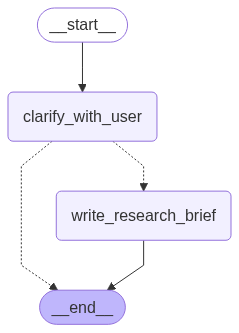

In [2]:
## Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from research_agent_scope import deep_researcher_builder

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [3]:
## Run the workflow
from research_utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in Toronto.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in Toronto.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What specific criteria are you looking for in a coffee shop (e.g. best coffee, atmosphere, location, etc.)?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
result = scope.invoke({"messages": [HumanMessage(content="Let's evaluate based on the quality of coffee to determine the best coffee shops in Toronto.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in Toronto.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What specific criteria are you looking for in a coffee shop (e.g. best coffee, atmosphere, location, etc.)?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's evaluate based on the quality of coffee to determine the best coffee shops in Toronto.                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You mentioned evaluating based on the quality of coffee. Can you please specify what you mean by 'quality of    │
│ coffee'? For example, are you looking for shops with high-rated coffee beans, expertly brewed coffee, or a      │
│ combination of both?                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result = scope.invoke({"messages": [HumanMessage(content="Let's evaluate based on the quality of coffee considering both high-rated coffee beans and brewing to determine the best coffee shops in Toronto.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in Toronto.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ What specific criteria are you looking for in a coffee shop (e.g. best coffee, atmosphere, location, etc.)?     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's evaluate based on the quality of coffee to determine the best coffee shops in Toronto.                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ You mentioned evaluating based on the quality of coffee. Can you please specify what you mean by 'quality of    │
│ coffee'? For example, are you looking for shops with high-rated coffee beans, expertly brewed coffee, or a      │
│ combination of both?                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's evaluate based on the quality of coffee considering both high-rated coffee beans and brewing to determine │
│ the best coffee shops in Toronto.                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have understood your request to evaluate the best coffee shops in Toronto based on high-rated coffee beans    │
│ and expertly brewed coffee. I will now begin researching and compiling a report with this criteria in mind.     │
│ Please note that my research will be conducted as of today's date, Saturday, September 6, 2025.                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
## Print the Research Brief
from rich.markdown import Markdown
Markdown(result["research_brief"])

As of September 6, 2025, I would like to conduct research on evaluating and ranking coffee shops in Toronto based  
on high-rated coffee beans and expertly brewed coffee. The evaluation criteria should consider both the quality of 
the coffee beans used and the expertise of the brewing methods employed by each coffee shop. Please compile a      
report that lists the top-performing coffee shops in Toronto according to these specific criteria, considering all 
price ranges unless cost constraints are specified.

## Scope Agent Evaluation

- Structure: Dataset >> Criteria >> Research Brief >> LLM Evaluator >> Evaluation Output
- Now, that we have tested our scope agent based on a particular prompt.
- Let's evaluate the individual components to check if everything is working as expected.

- Criteria for Research Brief:
    - 1. It captures all the relevant information from the user based on their prompted question
    - 2. It does not create an assumptions or assume a criteria that was not mentioned by the user

### Research Brief Evaluation 
- Let's test this using more examples

In [7]:
## Creating two new conversations
from langchain_core.messages import AIMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $75,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $75,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in Toronto, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in Toronto."),
    HumanMessage(content="I'd prefer to live in Eglinton, East York, or Liberty Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 4k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in September 2025."),
]

In [8]:
## Setting Criteria

criteria_1 = [
    "Current age is 25",
    "Desired retirement age is 45",
    "Current risk tolerance is high",
    "Interested in investing in stocks and ETFs",
    "Open to forms of investment beyond stocks and ETFs"
    "Investment account is a regular brokerage account",
]

criteria_2 = [
    "Looking for a 2 bed 2 bath apartment in Eglinton, East York, or Liberty Village",
    "Monthly rent below 4k",
    "Should be in a doorman building",
    "Ideally have an in unit washer and dryer but not strict",
    "Ideally have a gym but not strict",
    "Move in date is September 2025"
]

## Running the Code

- The above experiments are going to be run on LangSmith

- Running experiments in LangSmith
    - 1. Creating the dataset
    - 2. Writing the evaluator/s
    - 3. Running the experiment

In [12]:
## Let's create the dataset and run the above examples using LangSmith

import os
from dotenv import load_dotenv
from langsmith import Client

## Initialize the LangSmith client
## Here, the api_connect.env file stores the LangSmith API Key
load_dotenv("api_connect.env")
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

## Create the dataset
dataset_name = "deep_research_scoping"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that measures the quality of research briefs generated from an input conversation",
    )

    ## Add examples to the dataset
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"messages": conversation_1},
                "outputs": {"criteria": criteria_1},
            },
            {
                "inputs": {"messages": conversation_2},
                "outputs": {"criteria": criteria_2},
            },
        ],
    )

## Research Brief Evaluator

- Now, We will create an evaluator that compares the Research Brief with the Criteria based on our example
- Here, We will use the LLM as an evaluator to test our Research Brief and check if all criteria's are satisfied

- Criteria for Research Brief Evaluator  
    - 1. Role Definition: A proper role definition for the evaluator based on the evaluation domain
    - 2. Task Specification: Pass/Fail Judgements and set task boundaries and objectives, no ambiguous scoring method
    - 3. Background Context: Provide domian-specific context and check brief quality and importance of accurate evaluation 
    - 4. XML Tags: Structured XML Tags for different sections and clear specification of roles, tasks, input, judgements, etc
    - 5. Explicit Guidelines: Provide judgements for multiple examples and edge case handling with decision boundaries
    - 6. Output Instructions: Clear guidance for evaluation criteria and handling ambiguous cases 
    - 7. Bias Reduction: Fair assessment to balance precision and recall and if not sure lean towards conservative judgement 

In [13]:
from deep_research_prompts.prompts import BRIEF_CRITERIA_PROMPT
show_prompt(BRIEF_CRITERIA_PROMPT, "BRIEF_CRITERIA_PROMPT")

╭───────────────────────────────────────────── BRIEF_CRITERIA_PROMPT ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are an expert research brief evaluator specializing in assessing whether generated research briefs         │
│  accurately capture user-specified criteria without loss of important details.                                  │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief adequately captures the specific success criterion provided. Return a binary   │
│  assessment with detailed reasoning.                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs are critical for guiding downstream research agents. Missing or inadequately captured          │
│  criteria can lead to incomplete research that fails to address user needs. Accurate evaluation ensures         │
│  research quality and user satisfaction.                                                                        │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <criterion_to_evaluate>                                                                                        │
│  {criterion}                                                                                                    │
│  </criterion_to_evaluate>                                                                                       │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  CAPTURED (criterion is adequately represented) if:                                                             │
│  - The research brief explicitly mentions or directly addresses the criterion                                   │
│  - The brief contains equivalent language or concepts that clearly cover the criterion                          │
│  - The criterion's intent is preserved even if worded differently                                               │
│  - All key aspects of the criterion are represented in the brief                                                │
│                                                                                                                 │
│  NOT CAPTURED (criterion is missing or inadequately ad

In [14]:
## Defining Evaluators for our dataset

from typing_extensions import cast
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model

class Criteria(BaseModel):
    """
    Individual success criteria evaluation result.
    
    This model represents a single evaluation criteria that should be present
    in the research brief, along with a detailed assessment of whether it was
    successfully captured and the reasoning behind that assessment.
    """
    criteria_text: str = Field(
        description="The specific success criteria being evaluated (e.g., 'Current age is 25', 'Monthly rent below 7k')"
    )
    reasoning: str = Field(
        description="Detailed explanation of why this criteria is or isn't captured in the research brief, including specific evidence from the brief"
    )
    is_captured: bool = Field(
        description="Whether this specific criteria is adequately captured in the research brief (True) or missing/inadequately addressed (False)"
    )

def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief captures all required success criteria.
    
    This function evaluates each criterion individually to provide focused assessment
    and detailed reasoning for each evaluation decision.
    
    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the list of success criteria
        
    Returns:
        Dict with evaluation results including score (0.0 to 1.0)
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]

    model = init_chat_model(model="ollama:llama3.1:8b", temperature=0.4)
    structured_output_model = model.with_structured_output(Criteria)
    
    ## Run evaluations based on criteria
    responses = structured_output_model.batch([
    [
        HumanMessage(
            content=BRIEF_CRITERIA_PROMPT.format(
                research_brief=research_brief,
                criterion=criterion
            )
        )
    ] 
    for criterion in success_criteria])
    
    ## Ensure the criteria_text field is populated correctly
    individual_evaluations = [
        Criteria(
            reasoning=response.reasoning,
            criteria_text=criterion,
            is_captured=response.is_captured
        )
        for criterion, response in zip(success_criteria, responses)
    ]
    
    ## Calculate overall score as percentage of captured criteria
    captured_count = sum(1 for eval_result in individual_evaluations if eval_result.is_captured)
    total_count = len(individual_evaluations)
    
    return {
        "key": "success_criteria_score", 
        "score": captured_count / total_count if total_count > 0 else 0.0,
        "individual_evaluations": [
            {
                "criteria": eval_result.criteria_text,
                "captured": eval_result.is_captured,
                "reasoning": eval_result.reasoning
            }
            for eval_result in individual_evaluations
        ]
    }

In [ ]:
## Checks if the Research Brief didn't make any assumptions and evaluates criteria
## Multiple Examples passed so the model is able to learn and produce correct evaluations
from deep_research_prompts.prompts import BRIEF_HALLUCINATION_PROMPT
show_prompt(BRIEF_HALLUCINATION_PROMPT, "BRIEF_HALLUCINATION_PROMPT")

╭────────────────────────────────────────── BRIEF_HALLUCINATION_PROMPT ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  ## Brief Hallucination Evaluator                                                                               │
│                                                                                                                 │
│  <role>                                                                                                         │
│  You are a meticulous research brief auditor specializing in identifying unwarranted assumptions that could     │
│  mislead research efforts.                                                                                      │
│  </role>                                                                                                        │
│                                                                                                                 │
│  <task>                                                                                                         │
│  Determine if the research brief makes assumptions beyond what the user explicitly provided. Return a binary    │
│  pass/fail judgment.                                                                                            │
│  </task>                                                                                                        │
│                                                                                                                 │
│  <evaluation_context>                                                                                           │
│  Research briefs should only include requirements, preferences, and constraints that users explicitly stated    │
│  or clearly implied. Adding assumptions can lead to research that misses the user's actual needs.               │
│  </evaluation_context>                                                                                          │
│                                                                                                                 │
│  <research_brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </research_brief>                                                                                              │
│                                                                                                                 │
│  <success_criteria>                                                                                             │
│  {success_criteria}                                                                                             │
│  </success_criteria>                                                                                            │
│                                                                                                                 │
│  <evaluation_guidelines>                                                                                        │
│  PASS (no unwarranted assumptions) if:                                                                          │
│  - Brief only includes explicitly stated user requirements                                                      │
│  - Any inferences are clearly marked as such or logically necessary                                             │
│  - Source suggestions are general recommendations, not specific assumptions                                     │
│  - Brief stays within the scope of what the user actually requested                                             │
│                                                       

In [16]:
## Defining Criteria for No assumptions for the model
class NoAssumptions(BaseModel):
    """
    Evaluation model for checking if research brief makes unwarranted assumptions.
    
    This model evaluates whether the research brief contains any assumptions,
    inferences, or additions that were not explicitly stated by the user in their
    original conversation. It provides detailed reasoning for the evaluation decision.
    """
    no_assumptions: bool = Field(
        description="Whether the research brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated."
    )
    reasoning: str = Field(
        description="Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements."
    )

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief avoids making unwarranted assumptions.
    
    This evaluator checks that the research brief only includes information
    and requirements that were explicitly provided by the user, without
    making assumptions about unstated preferences or requirements.
    
    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the success criteria for reference
        
    Returns:
        Dict with evaluation results including boolean score and detailed reasoning
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]
    
    model = init_chat_model(model="ollama:llama3.1:8b", temperature=0.4)
    structured_output_model = model.with_structured_output(NoAssumptions)
    
    response = structured_output_model.invoke([
        HumanMessage(content=BRIEF_HALLUCINATION_PROMPT.format(
            research_brief=research_brief, 
            success_criteria=str(success_criteria)
        ))
    ])
    
    return {
        "key": "no_assumptions_score", 
        "score": response.no_assumptions,
        "reasoning": response.reasoning
    }

## Running the Experiment using LangSmith

In [17]:
import uuid

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return scope.invoke(inputs, config=config)

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    experiment_prefix="Deep Research Scoping",
)

View the evaluation results for experiment: 'Deep Research Scoping-95e577c3' at:
https://smith.langchain.com/o/7f9b00dd-1fb4-43be-b697-24cb112bddff/datasets/568d58ad-7d7d-478c-a60d-77a853e06cd1/compare?selectedSessions=991019bd-23ad-4836-9aa3-1b3779453c70




c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator evaluate_success_criteria> on run f97790cd-da4d-44fb-a18f-f401e016c720: KeyError('research_brief')
Traceback (most recent call last):
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\langsmith\evaluation\_runner.py", line 1620, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(  # type: ignore[call-arg]
        run=run,
        example=example,
        evaluator_run_id=evaluator_run_id,
    )
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\langsmith\evaluation\evaluator.py", line 351, in evaluate_run
    result = self.func(
        run,
        example,
        langsm

,inputs.messages,outputs.messages,outputs.supervisor_messages,outputs.raw_notes,outputs.notes,error,reference.criteria,feedback.wrapper,execution_time,example_id,id
0,"[{'type': 'human', 'content': 'I am looking fo...",[content='I am looking for an apartment in Tor...,[],[],[],None,[Looking for a 2 bed 2 bath apartment in Eglin...,None,42.618308,1ff21258-8fdb-493f-8c0f-bc551ffebb91,f97790cd-da4d-44fb-a18f-f401e016c720
1,"[{'type': 'human', 'content': 'What's the best...","[content=""What's the best way to invest $75,00...",[],[],[],None,"[Current age is 25, Desired retirement age is ...",None,23.938848,61b1e4b7-6567-4403-bf7f-870d4056f873,4e949239-525f-443f-9985-1c37eb73dd58
